Ari Sulistiyo Prabowo

This notebook is a test that is given by BagiData company to apply a job as Data Scientist. There are two test including:
- Spam Comment Classification
- News Title Classification

#Spam Comment Classification

In this test, I have to make a machine learning model to detect whether the comment is spam or not using **comment spam.xlsx** data. The result should be 0 means not spam and 1 means spam. 

**Flowchart to this task**

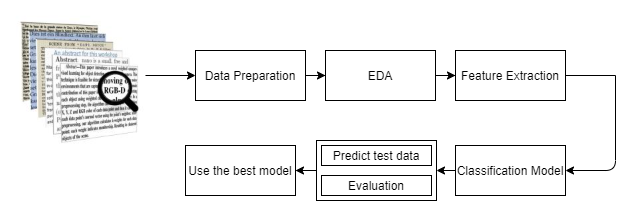

There are several steps to do this model:

**1. Data Preparation**
- Taking care the NaN Values and duplicate values

**2. Exploratory Data Analysis**
- Using WordCloud to show the most words in comment whether spam and not spam

**3. Text Cleaning & Data Pre-processing**
- Tokenizing the text
- Text Representations Vectorization

**4. Modelling Classification**
- SVC Classifier
- Decision Tree
- Naive Bayes
- Assesing the model using Learning Curve

**5. Prediction**

**6. Summary**

## 1. Data Preparation

In [1]:
#import library
import pandas as pd
import numpy as np

#visualization library
import matplotlib.pyplot as plt
import seaborn as sns

#wordcloud library
from wordcloud import WordCloud, STOPWORDS
import datetime, nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

#machine learning library
from sklearn import svm
from sklearn import preprocessing, metrics, feature_selection
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
#connecting dataset from google drive
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#read the dataset
directory = '/content/drive/My Drive/Data Ari/Data Science/Coding Test/BagiData'
comment_data = pd.ExcelFile(f'{directory}/Comment Spam.xls')
comment_data.sheet_names

['Data Train']

In [4]:
#read the dataset and specific sheet
comment_data = pd.read_excel(f'{directory}/Comment Spam.xls', sheet_name='Data Train')
comment_data = comment_data.iloc[:,1:] #skip the first column
comment_data.head()

,Comment,Class
0,this song is racist,0
1,and how many subscribers compared to her over ...,1
2,HI! CHECK OUT OUR AWESOME COVERS! AND SAY WHAT...,1
3,well done shakira,0
4,:D subscribe to me for daily vines,1


### 1.1 Taking Care NaN and Duplicate Values

In this section, I am curious on any null values and duplicate values. This null and duplicate values will affect the future modelling. 

In [5]:
#dimension of data
print("There are {} rows and {} columns".format(comment_data.shape[0], comment_data.shape[1]))

#type of variable and null values
type_null = pd.DataFrame(comment_data.dtypes).T.rename(index = {0:'Columns Type'})
type_null = type_null.append(pd.DataFrame(comment_data.isnull().sum()).T.rename(index = {0:'Amount of Null Values'}))
type_null = type_null.append(pd.DataFrame(comment_data.isnull().sum()/comment_data.shape[0]*100).T.rename(index = {0:'Percentage of Null Values'}))
display(type_null)

#drop duplicate values
comment_data.drop_duplicates(inplace=True)

print("")
print("There are {} rows and {} columns left".format(comment_data.shape[0], comment_data.shape[1]))


There are 1300 rows and 2 columns


,Comment,Class
Columns Type,object,int64
Amount of Null Values,0,0
Percentage of Null Values,0,0



There are 1162 rows and 2 columns left


The result from section 1 shows that **there are no null values** and around **10.6%** data has been dropped due to any data duplications

## 2. Exploratory Data Analysis

### 2.1 WordCloud to analyse the most words in comment

In this section, I am going to show the variation and the most word appear in the comment column

In [6]:
#stopwords are used to remove any redundant words
stopwords = set(STOPWORDS)

In [7]:
#setting the wordcloud
words_comment = WordCloud(background_color='white', max_words=2000,
                          stopwords=stopwords)

#generate the word cloud
text = " ".join(comment for comment in comment_data['Comment'])
words_comment.generate(text)

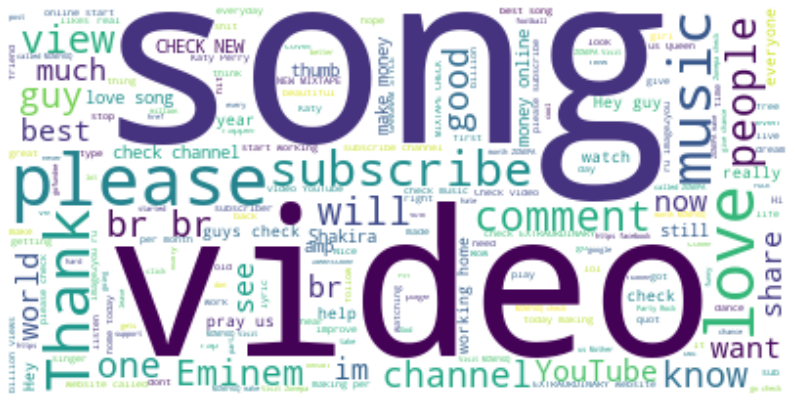

In [8]:
#display the generated image:
fig = plt.figure()
fig.set_figwidth(14)
fig.set_figheight(18)
plt.imshow(words_comment, interpolation='bilinear')
plt.axis('off')
plt.show()

This section shows to us that most of comment contains words of **SONG** and **VIDEO**, and some of the comment relates on YouTube. 

However, in the next section I am going to remove any punctuation in order to make any data more robust and very clear.

## 3. Text Cleaning and Data Pre-processing

### 3.1 Tokenizing the text

What is tokenizing?

Tokenization is the process of breaking down a stram of the text into words, phrases, symbol, or any other meaningful elements called tokens. The goal of tokenization is to extract the individual words in a sentence. 

In this section, I will handle the noise in the text such as punctuation, abbreviation of the text corpus.

In [9]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [10]:
def process_text(text):
  from nltk.corpus import stopwords 
  from nltk.tokenize import word_tokenize
  
  #remove the punction that is not important
  nopunc = [char for char in text if char not in string.punctuation]
  nopunc = ''.join(nopunc)
  
  #remove useless word in data
  stop_words = set(stopwords.words('english')) 
  
  word_tokens = word_tokenize(nopunc) 
  
  clean_words = [w for w in word_tokens if not w in stop_words] 
  return clean_words

In [11]:
comment_data['Comment'].head().apply(process_text)

0                                       [song, racist]
1               [many, subscribers, compared, million]
2    [HI, CHECK, OUT, OUR, AWESOME, COVERS, AND, SA...
3                                [well, done, shakira]
4                         [D, subscribe, daily, vines]
Name: Comment, dtype: object

### 3.2 Text Representations Vectorization

In this section, I am going to use sklearn library **CounterVectorizer**

CounterVectorizer provides a simple way to both build a vocabulary of known words and tokenize a collection of text, but also to encode new documents using that vocabulary.

An encoded vector is returned with a length of the entire vocabulary and an integer count for the number of times each word appeared. 

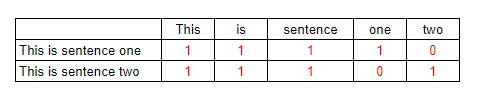

In [12]:
#Convert a collection of text documents to a matrix of token counts
from sklearn.feature_extraction.text import CountVectorizer
message_bow = CountVectorizer(analyzer=process_text).fit_transform(comment_data['Comment'])
message_bow.shape

(1162, 4154)

In [13]:
#split the dataset into 80% training data and 20% testing data
X_train, X_test, y_train, y_test = train_test_split(message_bow, comment_data['Class'], test_size=0.20, random_state=0)

Now, I have finished pre-processing the data. The next section will create the model and choose the best type of model

## 4. Modeling Classification

In [14]:
class Class(object):
    def __init__(self, clf, params=None):
        if params:
            self.clf = clf(**params)
        else:
            self.clf = clf()
            
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
        
    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict_test(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Testing Accuracy: {:.2f}%".format(100*metrics.accuracy_score(Y, self.predictions)))

    def grid_predict_train(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Training Accuracy: {:.2f}%".format(100*metrics.accuracy_score(Y, self.predictions)))

In [15]:
def plot_learning_curve(estimator, title, X, Y, ylim = None, cv = None,
                       n_jobs = 1, train_sizes = np.linspace(.1, 1.0, 10)):
    """
    Generate the plot of test and training learning curve
    """
    sns.set_style("dark")
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training Sample')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(estimator,
                                                           X, Y, cv=cv, n_jobs=n_jobs,
                                                           train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha = 0.1, color = 'r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha = 0.1, color = 'g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label = 'Training Score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label = 'Cross-validation curve')
    
    plt.legend(loc='best')
    return plt

### 4.1 SVC Classifier

In [16]:
svc = Class(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C': np.logspace(-2, 2, 10)}], Kfold = 5)
svc.grid_fit(X = X_train, Y = y_train)
svc.grid_predict_test(X_test, y_test)
svc.grid_predict_train(X_train, y_train)

Testing Accuracy: 84.98%
Training Accuracy: 96.66%


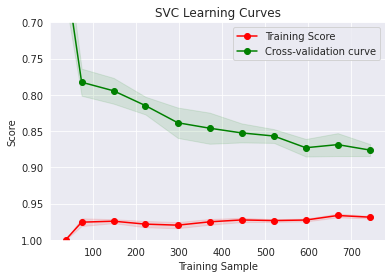

In [17]:
g = plot_learning_curve(svc.grid.best_estimator_, 'SVC Learning Curves',
                       X_train, y_train, ylim = [1.0, 0.7], cv = 5,
                       train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])


### 4.2 Decision Tree

In [18]:
dt = Class(clf = DecisionTreeClassifier)
dt.grid_search(parameters = [{'criterion':['entropy','gini'],
                              'max_features':['sqrt','log2']}], Kfold = 5)
dt.grid_fit(X= X_train, Y=y_train)
dt.grid_predict_test(X_test, y_test)
dt.grid_predict_train(X_train, y_train)

Testing Accuracy: 80.26%
Training Accuracy: 100.00%


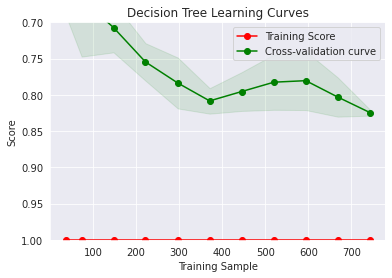

In [19]:
g = plot_learning_curve(dt.grid.best_estimator_, 'Decision Tree Learning Curves',
                       X_train, y_train, ylim = [1.0, 0.7], cv = 5,
                       train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])


### 4.3 Gradient Boosting

In [20]:
gb = Class(clf = GradientBoostingClassifier)
param_grid = {'n_estimators': [20, 40, 80, 100, 180, 200]}
gb.grid_search(parameters = param_grid, Kfold=5)
gb.grid_fit(X = X_train, Y = y_train)
gb.grid_predict_test(X_test, y_test)
gb.grid_predict_train(X_train, y_train)

Testing Accuracy: 86.70%
Training Accuracy: 91.39%


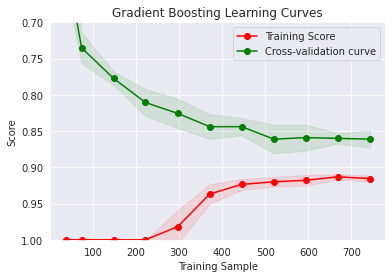

In [21]:
g = plot_learning_curve(gb.grid.best_estimator_, 'Gradient Boosting Learning Curves',
                       X_train, y_train, ylim = [1.0, 0.7], cv = 5,
                       train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])


### 4.4 Naive Bayes

In [22]:
clf = MultinomialNB().fit(X_train, y_train)
test_predict = clf.predict(X_test)
train_predict = clf.predict(X_train)
print("Testing Accuracy: {:.2f}%".format(100*metrics.accuracy_score(y_test, test_predict)))
print("Training Accuracy: {:.2f}%".format(100*metrics.accuracy_score(y_train, train_predict)))

Testing Accuracy: 83.26%
Training Accuracy: 97.31%


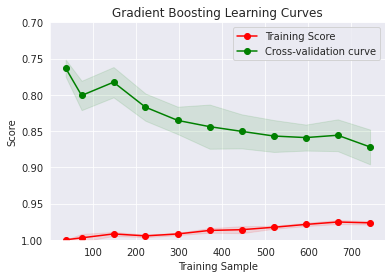

In [23]:
g = plot_learning_curve(MultinomialNB(), 'Gradient Boosting Learning Curves',
                       X_train, y_train, ylim = [1.0, 0.7], cv = 5,
                       train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])


Based on the metrics, It seems that Naive Bayes and Gradient Boosting are more reliable to overcome overfitting.

However, the highest score comes to the Gradient Boosting model instead of Naive Bayes. So, I will use this model to predict the data

## 5. Prediction

In [24]:
#using the gradient boosting model and execute the result
param_grid = {'n_estimators': [20, 40, 80, 100, 180, 200]}
model = GridSearchCV(GradientBoostingClassifier(),param_grid, cv = 5)
classifier = model.fit(X_train, y_train)

In [27]:
#show the prediction 
prediction = classifier.predict(X_test)
y_prediction = classifier.predict(X_test[5:15])
y_actual = y_test[5:15].values
data_prediction = {'y_prediction':y_prediction, 'y_actual':y_actual}
print('Accuracy: {:.2f}%'.format(100*metrics.accuracy_score(y_test, prediction)))
df = pd.DataFrame(data_prediction)
df

Accuracy: 86.27%


,y_prediction,y_actual
0,0,1
1,0,1
2,0,0
3,0,0
4,0,0
5,1,1
6,1,1
7,0,0
8,0,0
9,1,1


## 6. Summary

The goal of the task is to find whether the comment is spam or not. 

1. The first step that I do in here is making sure that there is no null values or duplicate values that will affect to the model.

2. The second step is looking for the trend in the comment and what I have is most of the comment is talking about video, song, love that intends on people. I use library called **WordCloud** to show this trend.

3. The third step is making sure that the comment does not contain any punctuation, abbreviation, and other unintended words that are not in dictionary. This step actually is in data pre-processing. I use library called **stopwords**, **tokenize**, and **CounterVectorizer**. The main of why I use this library to clean the text and create a vector of the text called **Bag of Words**

  - A brief explanation about **BoW** is the matrix with each word is dimension/column and each document is a row, and Cell values are counts of occurance.

4. The final step is modelling. I use several models in order to find which model is in good fit for this task. The result is Gradient Boosting with the **training accuracy is around 90%** and **testing accuracy is around 85%**.

How to improve the accuracy is in the step of **Data Pre-processing**. I use library CounterVectorizer in using **BoW** that counts every word occurs in a sentence. However, there is a potential issue that there might be some terms which occur frequently across all documents and these may tend to overshadow other terms in the feature set. So, to counter this issue, we can choose TF-IDF instead of BoW and I use TF-IDF in the second task.



